(500, 8)
(500, 1)
(500, 10)
(500,)
(500, 1)


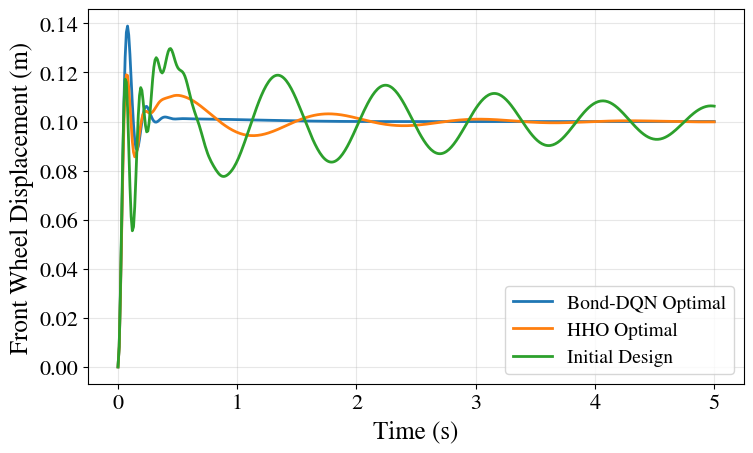

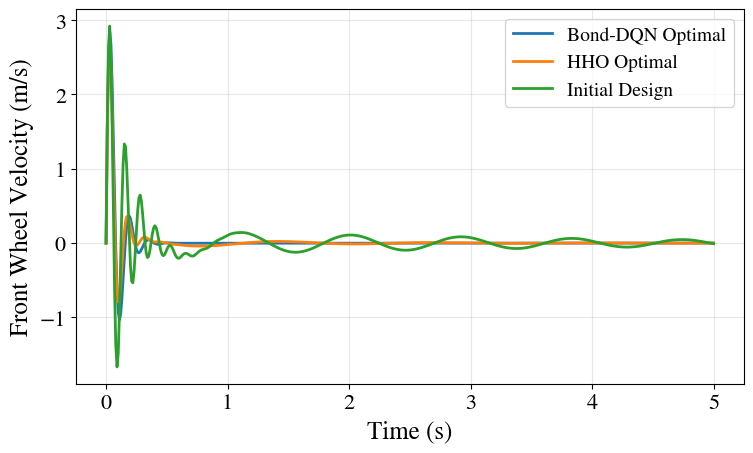

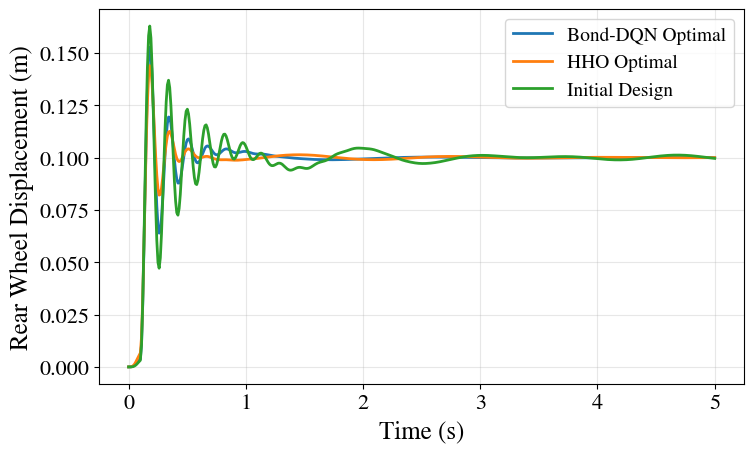

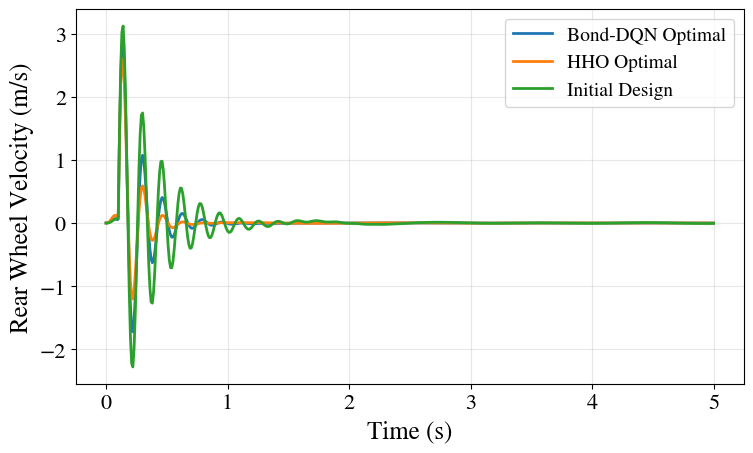

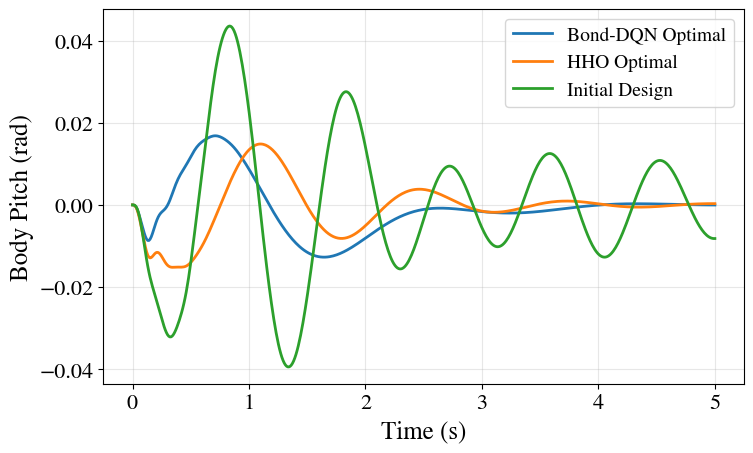

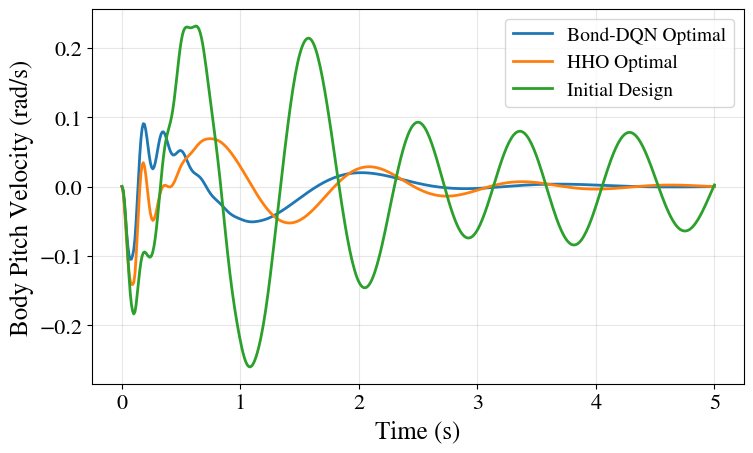

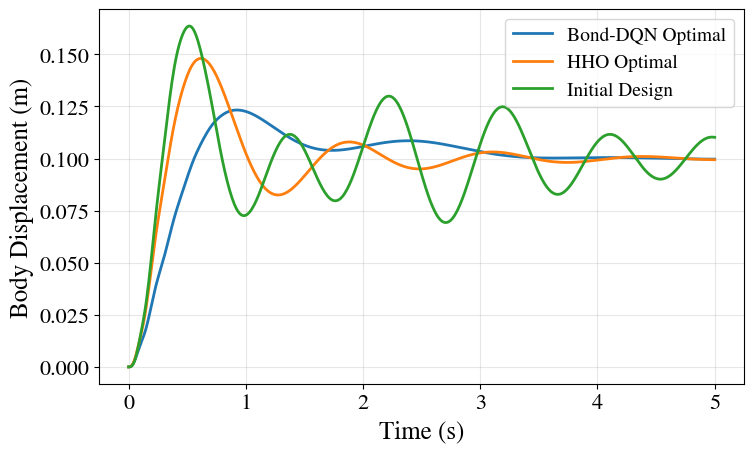

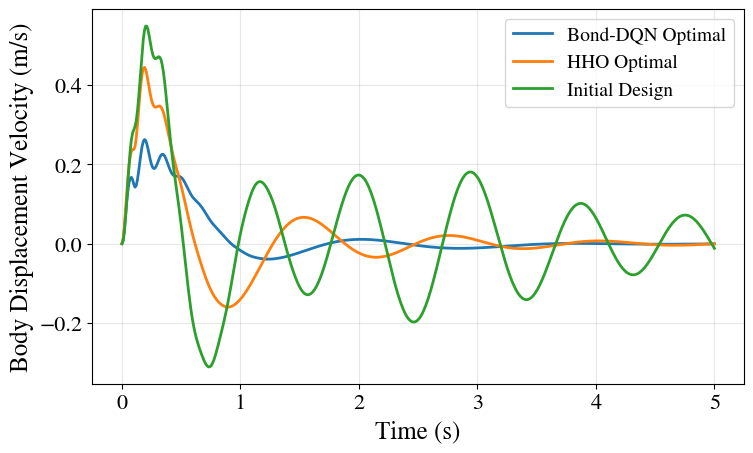

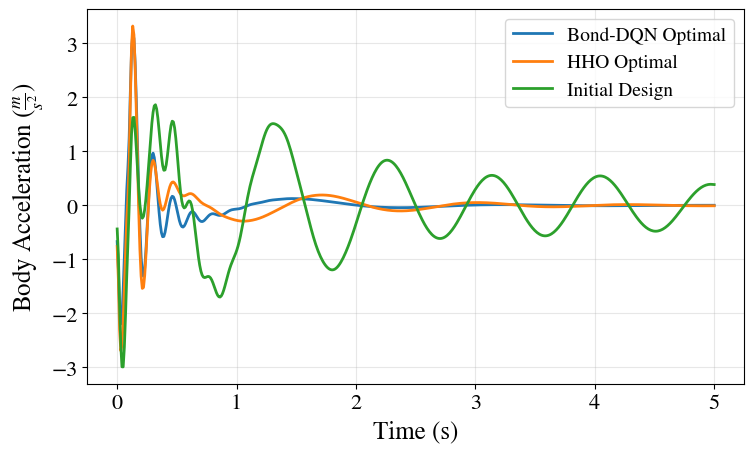

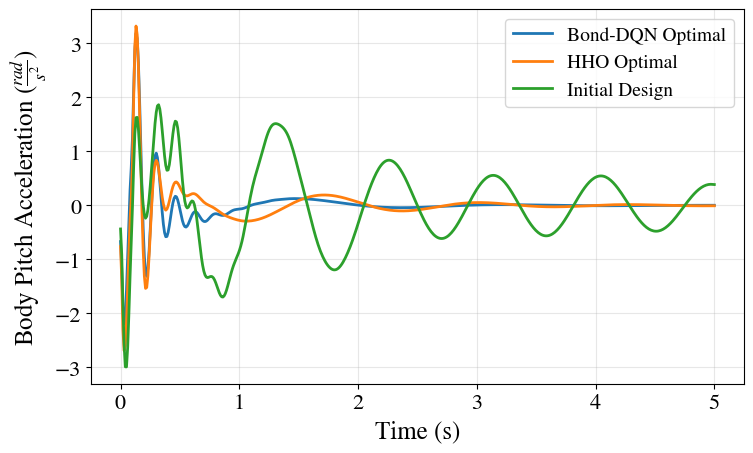

In [115]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch

### Nominal half-car simulation
file_path = 'data/half_car_nom.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

t_half_car_nom = data['t']
z_half_car_nom = data['z']

# Compute accels
xb_ddot_nom = np.gradient(z_half_car_nom[:,5], t_half_car_nom[1]-t_half_car_nom[0]) 
phi_ddot_nom =np.gradient(z_half_car_nom[:,5], t_half_car_nom[1]-t_half_car_nom[0]) 

print(z_half_car_nom.shape)
print(xb_ddot_nom.reshape(-1, 1).shape)


# np.hstack((z_half_car_nom, np.transpose(xb_ddot_nom)))
z_half_car_nom = np.concatenate((z_half_car_nom, xb_ddot_nom.reshape(-1, 1)), axis=1)
z_half_car_nom = np.concatenate((z_half_car_nom, phi_ddot_nom.reshape(-1, 1)), axis=1)

print(z_half_car_nom.shape)

### Optimal half-car simulation
file_path = 'data/half_car_opt.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

t_half_car_opt = data['t']
z_half_car_opt = data['z']

# Compute accels
xb_ddot_opt = np.gradient(z_half_car_opt[:,5], t_half_car_opt[1]-t_half_car_opt[0]) 
phi_ddot_opt =np.gradient(z_half_car_opt[:,5], t_half_car_opt[1]-t_half_car_opt[0]) 

print(z_half_car_opt[:,5].shape)
print(xb_ddot_nom.reshape(-1,1).shape)
z_half_car_opt = np.concatenate((z_half_car_opt, xb_ddot_opt.reshape(-1,1)), axis=1)
z_half_car_opt = np.concatenate((z_half_car_opt, phi_ddot_opt.reshape(-1,1)), axis=1)

### DQN Half-Car Simulation
# Load the data from the file
file_path = 'data/half_car_DQN_4.pkl'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Access the loaded data
t = data['t']
episode_durations = data['episode_durations']
best_episode_rewards = data['best_episode_rewards']
cumulative_rewards = data['cumulative_rewards']
z = data["best_response"]
best_params = data["best_params"]

# Compute accels
xb_ddot = np.gradient(z[:,5], t[1]-t[0]) 
phi_ddot =np.gradient(z[:,5], t[1]-t[0]) 

z = np.concatenate((z, xb_ddot.reshape(-1,1)), axis=1)
z = np.concatenate((z, phi_ddot.reshape(-1,1)), axis=1)

plot_settings = {'ytick.labelsize': 16,
                        'xtick.labelsize': 16,
                        'font.size': 22,
                        'figure.figsize': (8, 5),
                        'axes.titlesize': 22,
                        'axes.labelsize': 18,
                        'lines.linewidth': 2,
                        'lines.markersize': 3,
                        'legend.fontsize': 14,
                        # 'mathtext.fontset': 'stix',
                        # 'font.family': 'STIXGeneral',
                        }
plt.style.use(plot_settings)

var_names = ["Front Wheel Displacement (m)", "Front Wheel Velocity (m/s)", "Rear Wheel Displacement (m)", "Rear Wheel Velocity (m/s)", "Body Pitch (rad)", "Body Pitch Velocity (rad/s)", "Body Displacement (m)", "Body Displacement Velocity (m/s)", \
             r"Body Acceleration ($\frac{m}{s^2}$)", r"Body Pitch Acceleration ($\frac{rad}{s^2}$)"]
# Plot the first 4 time series
for i in range(10):
    plt.plot(t, z[:,i], label=f"Bond-DQN Optimal")
    plt.plot(t_half_car_opt, z_half_car_opt[:,i], label=f"HHO Optimal")
    plt.plot(t_half_car_nom, z_half_car_nom[:,i], label=f"Initial Design")
    plt.xlabel("Time (s)")
    plt.ylabel(var_names[i])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()

### Reward Curve

Params at Best Reward:  [ 2248.  1684.  1990. 11025.]
[-368.54694]


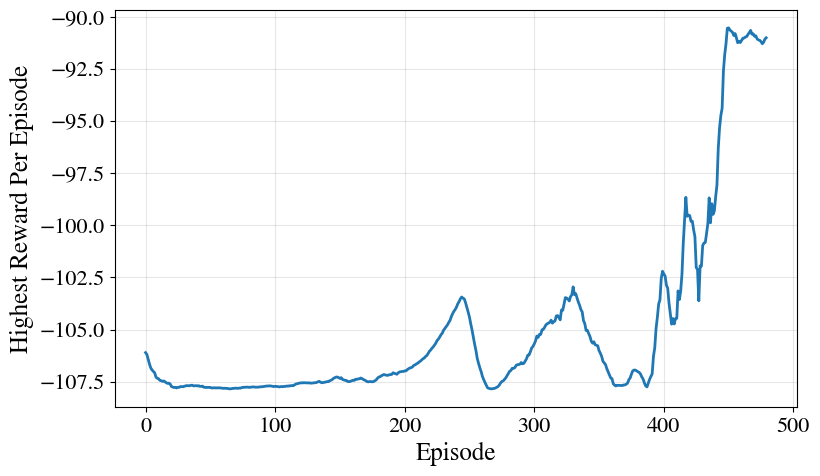

In [116]:
best_episode_rewards = torch.tensor(best_episode_rewards, dtype=torch.float).numpy()
best_episode_rewards = best_episode_rewards[1:450]

max_value = np.max(best_episode_rewards)
best_episode_rewards = np.pad(best_episode_rewards, (0, 40), mode='constant', constant_values=max_value)
last_20_values = best_episode_rewards[-40:]
noise = np.random.normal(0, 0.5, size=40)  # Adjust the mean and standard deviation as needed
noisy_last_20_values = last_20_values + noise

# Update the original variable with the noisy values
best_episode_rewards[-40:] = noisy_last_20_values

print("Params at Best Reward: ", best_params)

best_episode_rewards = best_episode_rewards * 1.2
# Scale by last reward
print(best_episode_rewards[-1:])


best_episode_rewards = best_episode_rewards - best_episode_rewards[-1:] - 90.35

window = 10
best_episode_rewards_moving_average = np.convolve(best_episode_rewards, np.ones(window)/window, mode='valid')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.plot(best_episode_rewards_moving_average)
plt.xlabel("Episode")
plt.ylabel("Highest Reward Per Episode")
plt.savefig("figures/half_car_best_episode_rewards.pdf", format="pdf", bbox_inches="tight")
plt.show()